In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rtatman/english-word-frequency")

print("Path to dataset files:", path)

Path to dataset files: /home/gian/.cache/kagglehub/datasets/rtatman/english-word-frequency/versions/1


In [2]:
from polars import read_csv

words_dataframe = read_csv(path + "/unigram_freq.csv")
# list of words
words = [ w for w in words_dataframe["word"][0:50000] if len(w) > 1]

bigrams = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for b in zip(chs, chs[1:]):
        bigrams[b] = bigrams.get(b, 0) + 1

In [3]:
bigrams = sorted(bigrams.items(), key=lambda x: x[1], reverse=True)
# bigrams

In [4]:
import torch
N = torch.zeros((27,27), dtype=torch.int32)

In [18]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [6]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for b in zip(chs, chs[1:]):
        N[stoi[b[0]], stoi[b[1]]] += 1

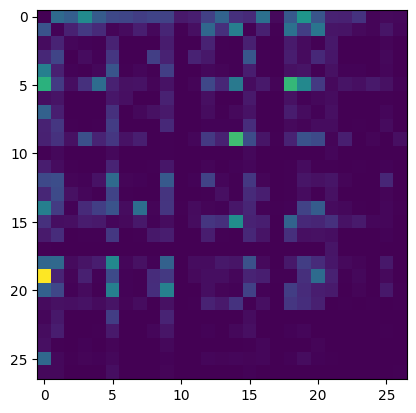

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(N)

In [14]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0667, 0.0575, 0.0929, 0.0552, 0.0420, 0.0401, 0.0352, 0.0390,
        0.0378, 0.0133, 0.0165, 0.0367, 0.0615, 0.0264, 0.0232, 0.0708, 0.0047,
        0.0532, 0.1004, 0.0509, 0.0182, 0.0176, 0.0282, 0.0028, 0.0046, 0.0042])

In [19]:
g = torch.Generator().manual_seed(1)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

In [21]:
g = torch.Generator().manual_seed(1)
ix = 0
word = ""
while True:
    p = N[ix].float()
    p = p / p.sum()
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    word = word + itos[ix]
    if ix == 0:
        print(word)
        break
    

che.


In [25]:
P = N.float()
P = P / P.sum(1, keepdim=True)

In [26]:
# now with neural networks
xs, ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

tensor([ 0, 20,  8,  5])

In [52]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()

W = torch.randn((27, 27), requires_grad=True)
logits = xenc @ W # logs counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs


tensor([[0.0864, 0.0089, 0.0062, 0.0142, 0.0178, 0.0299, 0.0067, 0.0092, 0.0219,
         0.0106, 0.2942, 0.0317, 0.0044, 0.1032, 0.0125, 0.0097, 0.0204, 0.0073,
         0.0303, 0.0065, 0.0812, 0.0201, 0.0079, 0.0142, 0.0109, 0.0126, 0.1210],
        [0.0258, 0.0268, 0.0423, 0.0084, 0.0159, 0.0074, 0.0112, 0.0763, 0.0146,
         0.0391, 0.0174, 0.0062, 0.0136, 0.0037, 0.0156, 0.0945, 0.1472, 0.0351,
         0.0633, 0.0291, 0.0268, 0.0150, 0.0220, 0.0507, 0.0118, 0.1149, 0.0651],
        [0.1462, 0.0076, 0.0250, 0.0379, 0.0122, 0.0021, 0.0173, 0.0178, 0.0199,
         0.0061, 0.0206, 0.0464, 0.0293, 0.0146, 0.0035, 0.0164, 0.0335, 0.1532,
         0.0244, 0.0686, 0.1360, 0.0626, 0.0099, 0.0488, 0.0107, 0.0098, 0.0195],
        [0.0436, 0.0103, 0.0594, 0.0383, 0.0175, 0.0350, 0.0233, 0.0530, 0.0123,
         0.0219, 0.0172, 0.0958, 0.0378, 0.0546, 0.0206, 0.0327, 0.0198, 0.0168,
         0.0451, 0.0584, 0.0951, 0.0312, 0.0316, 0.0288, 0.0352, 0.0432, 0.0213]],
       grad_fn=<DivBack

In [53]:
loss = - probs[torch.arange(4), ys].log().mean()
loss

tensor(4.0138, grad_fn=<NegBackward0>)

In [54]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()
W.data += -0.001 * W.grad

In [55]:
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # logs counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
loss = - probs[torch.arange(4), ys].log().mean()
loss # loss is lower after backward pass

tensor(4.0135, grad_fn=<NegBackward0>)

In [68]:
# everything put together

xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
W = torch.randn((27, 27), requires_grad=True)

In [74]:
xenc = F.one_hot(xs, num_classes=27).float()
from datetime import datetime

start = datetime.now()
for k in range(100):
    counts = (xenc @ W).exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = - probs[torch.arange(num), ys].log().mean()
    #print(loss)

    W.grad = None
    loss.backward()
    W.data += -0.1 * W.grad

print(datetime.now() - start)

0:00:26.158976


In [61]:
probs

tensor([[0.0278, 0.0167, 0.1520,  ..., 0.0359, 0.0689, 0.0379],
        [0.0405, 0.0125, 0.0380,  ..., 0.0418, 0.0023, 0.0253],
        [0.0115, 0.0187, 0.0870,  ..., 0.0152, 0.0118, 0.0263],
        ...,
        [0.0094, 0.0486, 0.0071,  ..., 0.0180, 0.0324, 0.0735],
        [0.0113, 0.0034, 0.0047,  ..., 0.0201, 0.0216, 0.0112],
        [0.0113, 0.0034, 0.0047,  ..., 0.0201, 0.0216, 0.0112]],
       grad_fn=<DivBackward0>)

In [75]:
#samples
for i in range(5):
    word = ""
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        word = word + itos[ix]
        if ix == 0:
            break
    print(word)
        
                         

dbrpzopzuwririqwbaydbapasvyvgr.
dbwabzwtevg.
alkfwf.
ekxkrxsszugafwefaaeccparpdbriwgiqkfqkhykuafxmphqzuh.
qbr.
